generate vol surface for daily data

In [1]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, os.getenv('SRC_PATH'))

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sqlite3
from src.volsurface import GridInterpVolSurface, KernelVolSurface

In [2]:
DB_PATH = os.getenv('DB_PATH')
CSV_PATH = os.getenv('CSV_PATH')
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

In [3]:
query = """
SELECT date, symbol, exdate, last_date, cp_flag, strike_price, best_bid, best_offer, volume, open_interest, impl_volatility, delta
FROM opprc
"""
dtype = {
    'symbol': 'string',
    'cp_flag': 'string',
    'strike_price': 'float64',
    'best_bid': 'float64',
    'best_offer': 'float64',
    'volume': 'int64',
    'open_interest': 'int64',
    'impl_volatility': 'float64',
    'delta': 'float64'
}
df_raw = pd.read_sql_query(query, conn, parse_dates=['date', 'exdate', 'last_date'])
df_raw = df_raw.replace('', np.nan) # sqlite returns empty strings for NULL values
df_raw = df_raw.astype(dtype)

idx_filter_bid = df_raw['best_bid'] > 0.0
idx_filter_spread = \
    (df_raw['best_offer'] - df_raw['best_bid'] >= 0.0) & \
    (((df_raw['best_offer'] - df_raw['best_bid']) / (df_raw['best_bid'] + df_raw['best_offer'] ) * 2) <= 0.1) # this alone filters about 6%
idx_filter_impl_vol = ~ df_raw['impl_volatility'].isna()
idx_filter_leverage = df_raw['delta'].abs().between(*np.nanquantile(df_raw['delta'].abs(), [0.01, 0.99]))
idx_filter_no_trade_consistency = (df_raw['volume'] > 0) == (df_raw['date'] == df_raw['last_date']) # probably corrupted data, current count of only 86

df = df_raw[
    idx_filter_bid & 
    idx_filter_spread & 
    idx_filter_impl_vol & 
    idx_filter_leverage & 
    idx_filter_no_trade_consistency
]

# print(f"Retained sample {df.shape[0] / df_raw.shape[0]:.2%}")

df['ttm'] = (df['exdate'] - df['date']).dt.days
df['days_since_last'] = (df['date'] - df['last_date']).dt.days
df['traded'] = df['volume'] > 0

df['consecutive_traded'] = df.groupby('symbol')['traded'].transform(
    lambda x: (x != x.shift(1)).cumsum()
)
df.loc[~df['traded'], 'consecutive_traded'] = np.nan

df['consecutive_traded_len'] = df.groupby(['symbol', 'consecutive_traded'])['traded'].transform('count')

def filter_consecutive_trading(df, consecutive_threshold):
    """
    Filter the DataFrame to include only rows where the options have been trading for at least n days consecutively.
    """
    consecutive_traded_start = df.loc[
        (df['traded']) &
        (df['consecutive_traded_len'] >= consecutive_threshold)]
    consecutive_traded_start = consecutive_traded_start.loc[
        (consecutive_traded_start.groupby('symbol').cumcount() == 0), 
        ['symbol', 'date']
    ].rename(columns={'date': 'consecutive_traded_start'})
    df_active = df.merge(
        consecutive_traded_start,
        how='left',
        on='symbol'
    )
    df_active = df_active[df_active['date'] >= df_active['consecutive_traded_start']]
    return df_active

df_active = filter_consecutive_trading(df, consecutive_threshold=5)

df_active['relative_spread'] = (df_active['best_offer'] - df_active['best_bid']) / (df_active['best_bid'] + df_active['best_offer'] ) * 2

/var/folders/dv/hcj1_ccx5cj5cw1rpkpk9x_h0000gn/T/ipykernel_87791/3092568098.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_raw = df_raw.replace('', np.nan) # sqlite returns empty strings for NULL values
/var/folders/dv/hcj1_ccx5cj5cw1rpkpk9x_h0000gn/T/ipykernel_87791/3092568098.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ttm'] = (df['exdate'] - df['date']).dt.days
/var/folders/dv/hcj1_ccx5cj5cw1rpkpk9x_h0000gn/T/ipykernel_87791/3092568098.py:39: SettingWithCopyWarning: 
A value is trying to be set

In [4]:
df_active.sample(5)

,date,symbol,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,ttm,days_since_last,traded,consecutive_traded,consecutive_traded_len,consecutive_traded_start,relative_spread
3322834,2023-08-01,SPXW 230929C4430000,2023-09-29,2023-08-01,C,4430000.0,216.5,218.8,2,634,0.144704,0.763107,59,0.0,True,33.0,3.0,2023-05-10,0.010567
3352667,2023-08-03,SPXW 230911C4500000,2023-09-11,2023-08-03,C,4500000.0,89.8,90.5,5,0,0.131276,0.560661,39,0.0,True,1.0,7.0,2023-08-03,0.007765
126673,2022-09-13,SPXW 220928P3985000,2022-09-28,2022-09-13,P,3985000.0,102.5,103.1,17,19,0.238888,-0.589446,15,0.0,True,4.0,5.0,2022-09-09,0.005837
3400079,2023-08-08,SPXW 231031C4575000,2023-10-31,2023-08-08,C,4575000.0,99.5,100.3,4,137,0.130524,0.474739,84,0.0,True,27.0,1.0,2023-07-12,0.008008
850651,2022-11-16,SPXW 230331P2800000,2023-03-31,2022-11-15,P,2800000.0,18.5,19.0,0,785,0.375974,-0.045993,135,1.0,False,NaN,NaN,2022-09-16,0.026667


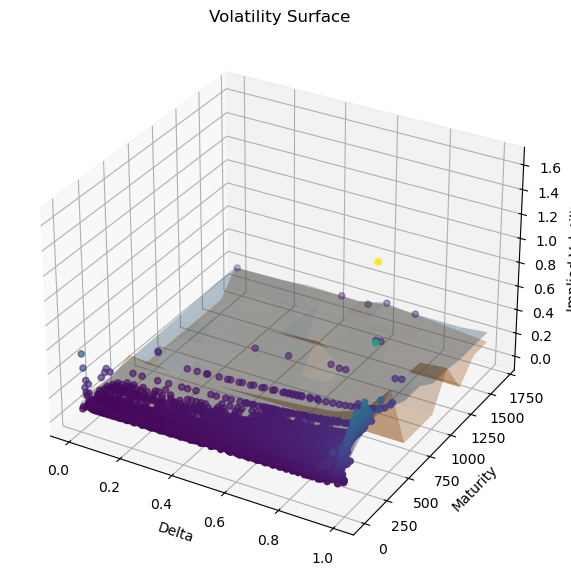

In [6]:
date = '2023-05-10'
delta = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] < 1e5), 'delta']
delta = np.where(delta > 0, delta, 1 + delta)
maturity = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] < 1e5), 'ttm']
vol = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] < 1e5), 'impl_volatility']
X = np.column_stack([delta, maturity])
y = vol

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(delta, maturity, vol, c=vol, cmap='viridis', marker='o')

ax.set_xlabel('Delta')
ax.set_ylabel('Maturity')
ax.set_zlabel('Volatility')
ax.set_title('3D Scatter Plot of Delta, Maturity, and Volatility')

interp_model_predictions = GridInterpVolSurface(kx=1, ky=1)
interp_model_predictions.fit(X, y)
interp_y_pred = interp_model_predictions.predict(X)

interp_model_predictions.plot(ax=ax, alpha=0.3)

kernel_model_predictions = KernelVolSurface()
kernel_model_predictions.fit(X, y)
kernel_y_pred = kernel_model_predictions.predict(X)
kernel_model_predictions.plot(ax=ax, alpha=0.3)


plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

# Define maturity thresholds
maturity_thresholds = [750, 1250, 1750, 1e5]

unique_dates = df_active['date'].unique()
results = {}

# Loop through each maturity threshold
for threshold in maturity_thresholds:
    print(f"Processing maturity threshold: {threshold}")
    results[threshold] = {}

    # Loop through each date
    for date in unique_dates:
        # print(f"  Processing date: {date}")

        # Filter data for the current date and maturity threshold
        delta = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] < threshold), 'delta']
        delta = np.where(delta > 0, delta, 1 + delta)  # Adjust delta values
        maturity = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] < threshold), 'ttm']
        vol = df_active.loc[(df_active['date'] == date) & (df_active['ttm'] < threshold), 'impl_volatility']

        # Skip if no data is available for the current date and threshold
        if len(delta) == 0 or len(maturity) == 0 or len(vol) == 0:
            print(f"    No data for date {date} and threshold {threshold}")
            continue

        # Prepare input data
        X = np.column_stack([delta, maturity])
        y = vol

        # Kernel Model
        kernel_model = KernelVolSurface()
        kernel_model.fit(X, y)
        kernel_y_pred = kernel_model.predict(X)

        # Calculate Mean Squared Error
        mse_kernel = mean_squared_error(y, kernel_y_pred)

        # Store results
        results[threshold][date] = {
            "mse_kernel": mse_kernel,
            "kernel_model": kernel_model,
            "kernel_y_pred": kernel_y_pred,
            "X": X,
            "y": y
        }

# Example: Access results for a specific threshold and date
threshold = 750
date = unique_dates[0]
if date in results[threshold]:
    print(f"\nResults for threshold {threshold} and date {date}:")
    print(f"MSE: {results[threshold][date]['mse_kernel']:.4f}")

Processing date: 2023-02-07T00:00:00.000000000
MSE for Grid Interpolation Model: 0.0015
MSE for Kernel Model: 0.0012
Processing date: 2022-12-21T00:00:00.000000000
MSE for Grid Interpolation Model: 0.0008
MSE for Kernel Model: 0.0003
Processing date: 2022-09-15T00:00:00.000000000
MSE for Grid Interpolation Model: 0.0004
MSE for Kernel Model: 0.0003
Processing date: 2022-09-22T00:00:00.000000000
MSE for Grid Interpolation Model: 0.0004
MSE for Kernel Model: 0.0003
Processing date: 2022-11-11T00:00:00.000000000
MSE for Grid Interpolation Model: 0.0008
MSE for Kernel Model: 0.0003

Date: 2023-02-07T00:00:00.000000000
Grid Interpolation MSE: 0.0015
Kernel Model MSE: 0.0012

Date: 2022-12-21T00:00:00.000000000
Grid Interpolation MSE: 0.0008
Kernel Model MSE: 0.0003

Date: 2022-09-15T00:00:00.000000000
Grid Interpolation MSE: 0.0004
Kernel Model MSE: 0.0003

Date: 2022-09-22T00:00:00.000000000
Grid Interpolation MSE: 0.0004
Kernel Model MSE: 0.0003

Date: 2022-11-11T00:00:00.000000000
Grid I

Predicted Volatility: [nan]


/opt/anaconda3/envs/vae-volsurface/lib/python3.10/site-packages/scipy/ndimage/_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


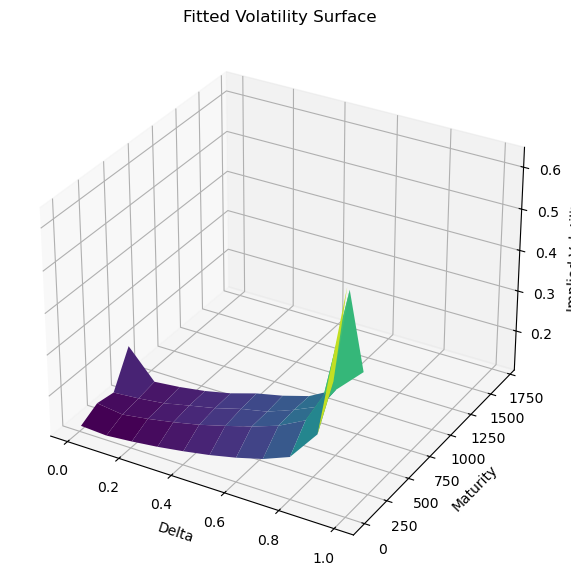

In [17]:
import numpy as np
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage import generic_filter

# Assuming delta, maturity, and vol are already defined in your notebook
delta = np.asarray(delta)
maturity = np.asarray(maturity)
vol = np.asarray(vol)

# Define delta and maturity grids (adjust resolution as needed)
delta_grid = np.linspace(np.min(delta), np.max(delta), 11)
maturity_grid = np.linspace(np.min(maturity), np.max(maturity), 11)

# Initialize grid for volatilities and counts
grid_vol = np.zeros((len(delta_grid), len(maturity_grid)))
counts = np.zeros_like(grid_vol, dtype=int)

# Map data points to grid indices
delta_idx = np.digitize(delta, delta_grid) - 1
maturity_idx = np.digitize(maturity, maturity_grid) - 1

# Aggregate volatilities into the grid
for i in range(len(vol)):
    d_idx, m_idx = delta_idx[i], maturity_idx[i]
    if 0 <= d_idx < len(delta_grid) and 0 <= m_idx < len(maturity_grid):
        grid_vol[d_idx, m_idx] += vol[i]
        counts[d_idx, m_idx] += 1

# Compute the average volatility for each grid cell
with np.errstate(invalid="ignore"):
    grid_vol = grid_vol / counts
    grid_vol[counts == 0] = np.nan  # Leave empty where no data

# Fill missing values (NaNs) with nearest neighbor interpolation
mask = np.isnan(grid_vol)
if np.any(mask):  # Only process if there are NaNs
    with np.errstate(invalid="ignore"):
        filled = generic_filter(grid_vol, np.nanmean, size=1, mode="nearest")
    grid_vol = np.where(mask, filled, grid_vol)

# Create the interpolation object
interp = RectBivariateSpline(delta_grid, maturity_grid, grid_vol, kx=3, ky=3)

# Example: Predict volatility for specific delta and maturity values
predicted_vol = interp.ev([0.5], [30])  # Example: delta=0.5, maturity=30 days
print(f"Predicted Volatility: {predicted_vol}")

# Visualize the fitted volatility surface
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

d, m = np.meshgrid(delta_grid, maturity_grid, indexing='ij')
ax.plot_surface(d, m, grid_vol, cmap='viridis')

ax.set_xlabel('Delta')
ax.set_ylabel('Maturity')
ax.set_zlabel('Implied Volatility')
ax.set_title('Fitted Volatility Surface')
plt.show()

In [18]:
grid_vol

array([[0.11591382, 0.13764415, 0.1299755 , 0.21256   ,        nan,
               nan,        nan,        nan,        nan,        nan,
        0.178688  ],
       [0.11206433, 0.12932911, 0.1351125 , 0.142684  ,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan],
       [0.11782007, 0.13877348, 0.142943  , 0.14913667,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan],
       [0.12521759, 0.15069431, 0.1570915 , 0.15894667,        nan,
        0.162346  ,        nan,        nan,        nan,        nan,
               nan],
       [0.13492809, 0.16467241, 0.17079511, 0.172977  ,        nan,
        0.183688  ,        nan,        nan,        nan,        nan,
        0.197239  ],
       [0.1463181 , 0.18227768, 0.18884033, 0.19255367,        nan,
               nan,        nan,        nan,        nan,        nan,
        0.189664  ],
       [0.16065898, 0.20096895, 0.20241248, 0.20674312,   

/opt/anaconda3/envs/vae-volsurface/lib/python3.10/site-packages/scipy/ndimage/_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


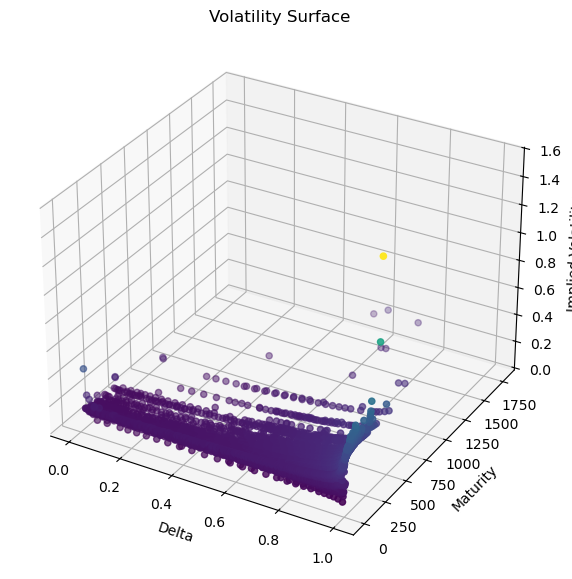

In [48]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(delta, maturity, vol, c=vol, cmap='viridis', marker='o')

ax.set_xlabel('Delta')
ax.set_ylabel('Maturity')
ax.set_zlabel('Volatility')
ax.set_title('3D Scatter Plot of Delta, Maturity, and Volatility')

interp_model = GridInterpVolSurface(kx=1, ky=1)
interp_model.fit(X, y)
interp_y_pred = interp_model.predict(X)

interp_model.plot(ax=ax, alpha=0.3)


plt.show()

In [49]:
interp_y_pred

array([nan, nan, nan, ..., nan, nan, nan], shape=(5212,))

In [ ]:
nan_indices = np.where(np.isnan(kernel_y_pred) | y.isna())[0]
nan_indices

array([   0,    1,    2, ..., 3204, 3205, 3206], shape=(3190,))